In [ ]:
from torcheeg.datasets import SEEDDataset
from torcheeg import transforms
raw_dataset = SEEDDataset(
    root_path='D:/FAST/EEg-based-Emotion-Recognition/Preprocessed_EEG',
    io_path='D:/FAST/EEg-based-Emotion-Recognition/.torcheeg/datasets_1733174610032_5iJyS',
    online_transform=None,
    label_transform=None,
    num_worker=4
)

raw_sample = raw_dataset[0]
print(f"Raw EEG data shape: {raw_sample[0].shape}")

[2024-12-07 22:01:51] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from D:/FAST/EEg-based-Emotion-Recognition/.torcheeg/datasets_1733174610032_5iJyS.


Raw EEG data shape: (62, 200)


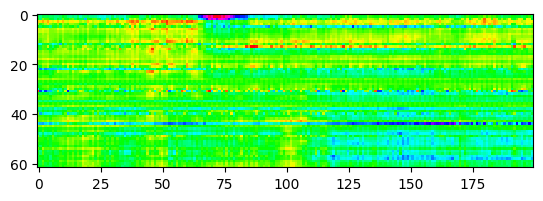

In [2]:
import torch
from torcheeg.utils import plot_2d_tensor

img = plot_2d_tensor(torch.tensor(raw_sample[0]))

In [3]:
from torcheeg.model_selection import LeaveOneSubjectOut
from torch.utils.data import DataLoader

print(f"Dataset contains {len(raw_dataset)} samples.")
print(f"Dataset size: {len(raw_sample)}")
print(f"Sample format: {raw_dataset[0]}")  # Check a single sample

Dataset contains 152730 samples.
Dataset size: 2
Sample format: (array([[-19.28210258,  -9.29832458, -25.77900887, ..., -15.55681229,
        -17.49396324, -19.90795135],
       [ 11.92092896,  20.53380013,  11.41428947, ...,   3.21865082,
         -1.16229057,  13.76867294],
       [  0.56624413,  18.80526543, -11.08646393, ..., -26.4942646 ,
        -23.66304398,   8.31484795],
       ...,
       [  3.4570694 ,  10.72883606,  -6.7949295 , ...,  12.54677773,
         10.46061516,  14.42432404],
       [  5.24520874,  11.77191734,  -3.66568565, ...,  15.07997513,
         11.41428947,  20.02716064],
       [  9.08970833,   6.34789467,   1.16229057, ...,  10.37120819,
         12.54677773,  17.94099808]]), {'start_at': 0, 'end_at': 200, 'clip_id': '10_20131130.mat_0', 'subject_id': 10, 'trial_id': 'ww_eeg1', 'emotion': 1, 'date': 20131130, '_record_id': '_record_0'})


In [ ]:
for i, sample in enumerate(raw_dataset):
    assert sample[0].shape == (62, 200), f"Mismatch at sample {i}"

In [4]:
from collections import defaultdict

# Organize data by emotion classes
emotion_classes = defaultdict(list)
for sample, metadata in raw_dataset:
    emotion = metadata['emotion']  # Assume emotion: -1 (negative), 0 (neutral), 1 (positive)
    emotion_classes[emotion].append((sample, metadata))
    
print({emotion: len(samples) for emotion, samples in emotion_classes.items()})


{1: 52650, 0: 49680, -1: 50400}


In [2]:
from scipy.signal import butter, lfilter

# Define bandpass filter
def bandpass_filter(data, lowcut=4, highcut=47, fs=200, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, data, axis=-1)

# Apply bandpass filter to dataset
def filter_dataset(dataset, lowcut=4, highcut=47, fs=200):
    filtered_dataset = []
    for sample, metadata in dataset:
        filtered_sample = bandpass_filter(sample, lowcut, highcut, fs)
        filtered_dataset.append((filtered_sample, metadata))
    return filtered_dataset

filtered_dataset = filter_dataset(raw_dataset)
print(len(filtered_dataset))

152730


In [ ]:
import torch
from torcheeg.utils import plot_2d_tensor

print(filtered_dataset[0][0].shape)

img = plot_2d_tensor(torch.tensor(filtered_dataset[0][0]))

In [ ]:
import mne
import numpy as np
import gc
import logging
from multiprocessing import Pool
import pickle

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s] %(message)s')

def process_sample_with_ica(args):
    sample, metadata, fs, n_components, max_iter = args
    logging.info(f"Starting ICA processing for metadata: {metadata}")
    try:
        info = mne.create_info(
            ch_names=[f'ch_{i}' for i in range(sample.shape[0])],
            sfreq=fs,
            ch_types='eeg'
        )
        raw = mne.io.RawArray(sample, info)
        logging.info(f"Raw data created for metadata: {metadata}")

        ica = mne.preprocessing.ICA(n_components=n_components, random_state=42, max_iter=max_iter, method='fastica')
        logging.info(f"Fitting ICA for sample with metadata: {metadata}")
        ica.fit(raw)

        logging.info(f"Applying ICA for sample with metadata: {metadata}")
        raw_cleaned = ica.apply(raw)

        logging.info(f"ICA completed successfully for metadata: {metadata}")
        return raw_cleaned.get_data(), metadata

    except ValueError as e:
        logging.warning(f"ValueError: {e} for sample with metadata: {metadata}. Skipping...")
    except Exception as e:
        logging.error(f"Unexpected error: {e} for sample with metadata: {metadata}. Skipping...")
    return None

def parallel_process_ica(dataset, fs=200, n_components=28, max_iter=800, batch_size=5, num_workers=2):
    cleaned_dataset = []
    logging.info(f"Starting ICA processing with n_components={n_components}, max_iter={max_iter}, batch_size={batch_size}, num_workers={num_workers}...")

    print("Before for loop")
    for start in range(0, len(dataset), batch_size):
        end = min(start + batch_size, len(dataset))
        batch = dataset[start:end]
        logging.info(f"Processing batch {start // batch_size + 1} with {len(batch)} samples...")

        print("Before args")
        args = [(sample, metadata, fs, n_components, max_iter) for sample, metadata in batch]
        print("After args")
        
        print("Before Pool")
        with Pool(num_workers) as p:
            results = p.map(process_sample_with_ica, args)
        print("After Pool")
        
        cleaned_dataset.extend([result for result in results if result is not None])

        del batch, results
        gc.collect()

    logging.info("ICA processing completed.")
    return cleaned_dataset

def save_results(cleaned_dataset, filename="cleaned_dataset.pkl"):
    with open(filename, "wb") as f:
        pickle.dump(cleaned_dataset, f)
    logging.info(f"Cleaned dataset saved to {filename}")

# Execute the script
if __name__ == "__main__":
    # Example: Test on a small dataset
    test_dataset = filtered_dataset[:10]
    cleaned_dataset = parallel_process_ica(test_dataset, fs=200, n_components=28, max_iter=800, batch_size=5, num_workers=2)
    save_results(cleaned_dataset, "test_cleaned_dataset.pkl")


2024-12-07 22:19:47,837 [INFO] Starting ICA processing with n_components=28, max_iter=800, batch_size=5, num_workers=2...
2024-12-07 22:19:47,947 [INFO] Processing batch 1 with 5 samples...


Before for loop
Before args
After args
Before Pool


In [6]:
import pickle

# Load the cleaned dataset
with open("test_cleaned_dataset.pkl", "rb") as f:import pickle

# Load the cleaned dataset
with open("test_cleaned_dataset.pkl", "rb") as f:
    cleaned_dataset = pickle.load(f)

# Check the length of the dataset
print(f"Number of samples in the cleaned dataset: {len(cleaned_dataset)}")

# Display metadata for each sample
for idx, (sample, metadata) in enumerate(cleaned_dataset):
    print(f"\nSample {idx + 1} Metadata:")
    for key, value in metadata.items():
        print(f"  {key}: {value}")

# Check the length of the dataset
print(f"Number of samples in the cleaned dataset: {len(cleaned_dataset)}")


Number of samples in the cleaned dataset: 10

Sample 1 Metadata:
  start_at: 200
  end_at: 400
  clip_id: 10_20131130.mat_1
  subject_id: 10
  trial_id: ww_eeg1
  emotion: 1
  date: 20131130
  _record_id: _record_0

Sample 2 Metadata:
  start_at: 0
  end_at: 200
  clip_id: 10_20131130.mat_0
  subject_id: 10
  trial_id: ww_eeg1
  emotion: 1
  date: 20131130
  _record_id: _record_0

Sample 3 Metadata:
  start_at: 400
  end_at: 600
  clip_id: 10_20131130.mat_2
  subject_id: 10
  trial_id: ww_eeg1
  emotion: 1
  date: 20131130
  _record_id: _record_0

Sample 4 Metadata:
  start_at: 600
  end_at: 800
  clip_id: 10_20131130.mat_3
  subject_id: 10
  trial_id: ww_eeg1
  emotion: 1
  date: 20131130
  _record_id: _record_0

Sample 5 Metadata:
  start_at: 800
  end_at: 1000
  clip_id: 10_20131130.mat_4
  subject_id: 10
  trial_id: ww_eeg1
  emotion: 1
  date: 20131130
  _record_id: _record_0

Sample 6 Metadata:
  start_at: 1000
  end_at: 1200
  clip_id: 10_20131130.mat_5
  subject_id: 10
  trial_

In [2]:
# Inspect the first sample
first_sample, metadata = cleaned_dataset[0]

# Print metadata
print("Metadata for the first sample:")
print(metadata)

# Print the shape of the cleaned EEG data
print(f"Shape of the cleaned EEG data: {first_sample.shape}")

# Display a portion of the cleaned EEG data
print("Cleaned EEG data (first 5 channels, first 10 time points):")
print(first_sample[:5, :10])


Metadata for the first sample:
{'start_at': 200, 'end_at': 400, 'clip_id': '10_20131130.mat_1', 'subject_id': 10, 'trial_id': 'ww_eeg1', 'emotion': 1, 'date': 20131130, '_record_id': '_record_0'}
Shape of the cleaned EEG data: (62, 200)
Cleaned EEG data (first 5 channels, first 10 time points):
[[-1.24508363e+00 -5.03617124e+00 -7.96300877e+00 -6.51692624e+00
  -3.57215765e+00 -1.24041013e+00  1.41330206e+00  2.40836839e+00
   1.63427171e+00  3.38140234e+00]
 [ 4.30722207e-01  2.64797981e+00  6.63880277e+00  8.46982662e+00
   4.30952448e+00 -3.92310321e+00 -9.72402791e+00 -8.61405128e+00
  -3.36331957e+00 -7.04046690e-03]
 [-1.13173568e+00 -5.29154900e+00 -8.72383528e+00 -4.62131968e+00
   1.60676589e+00 -2.89241460e-02 -3.51632695e+00  9.60381603e-01
   7.87548183e+00  7.90229392e+00]
 [-1.42120890e+00 -6.22984654e+00 -9.95607070e+00 -6.44164190e+00
  -2.18677384e+00 -5.07669630e+00 -7.77400048e+00 -2.65766974e+00
   5.31809190e+00  9.42388443e+00]
 [-9.57354218e-01 -4.32117726e+00 -6

C:\Users\hasee\AppData\Local\Temp\ipykernel_6688\3685621684.py:13: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Adjust subplots to avoid overlap


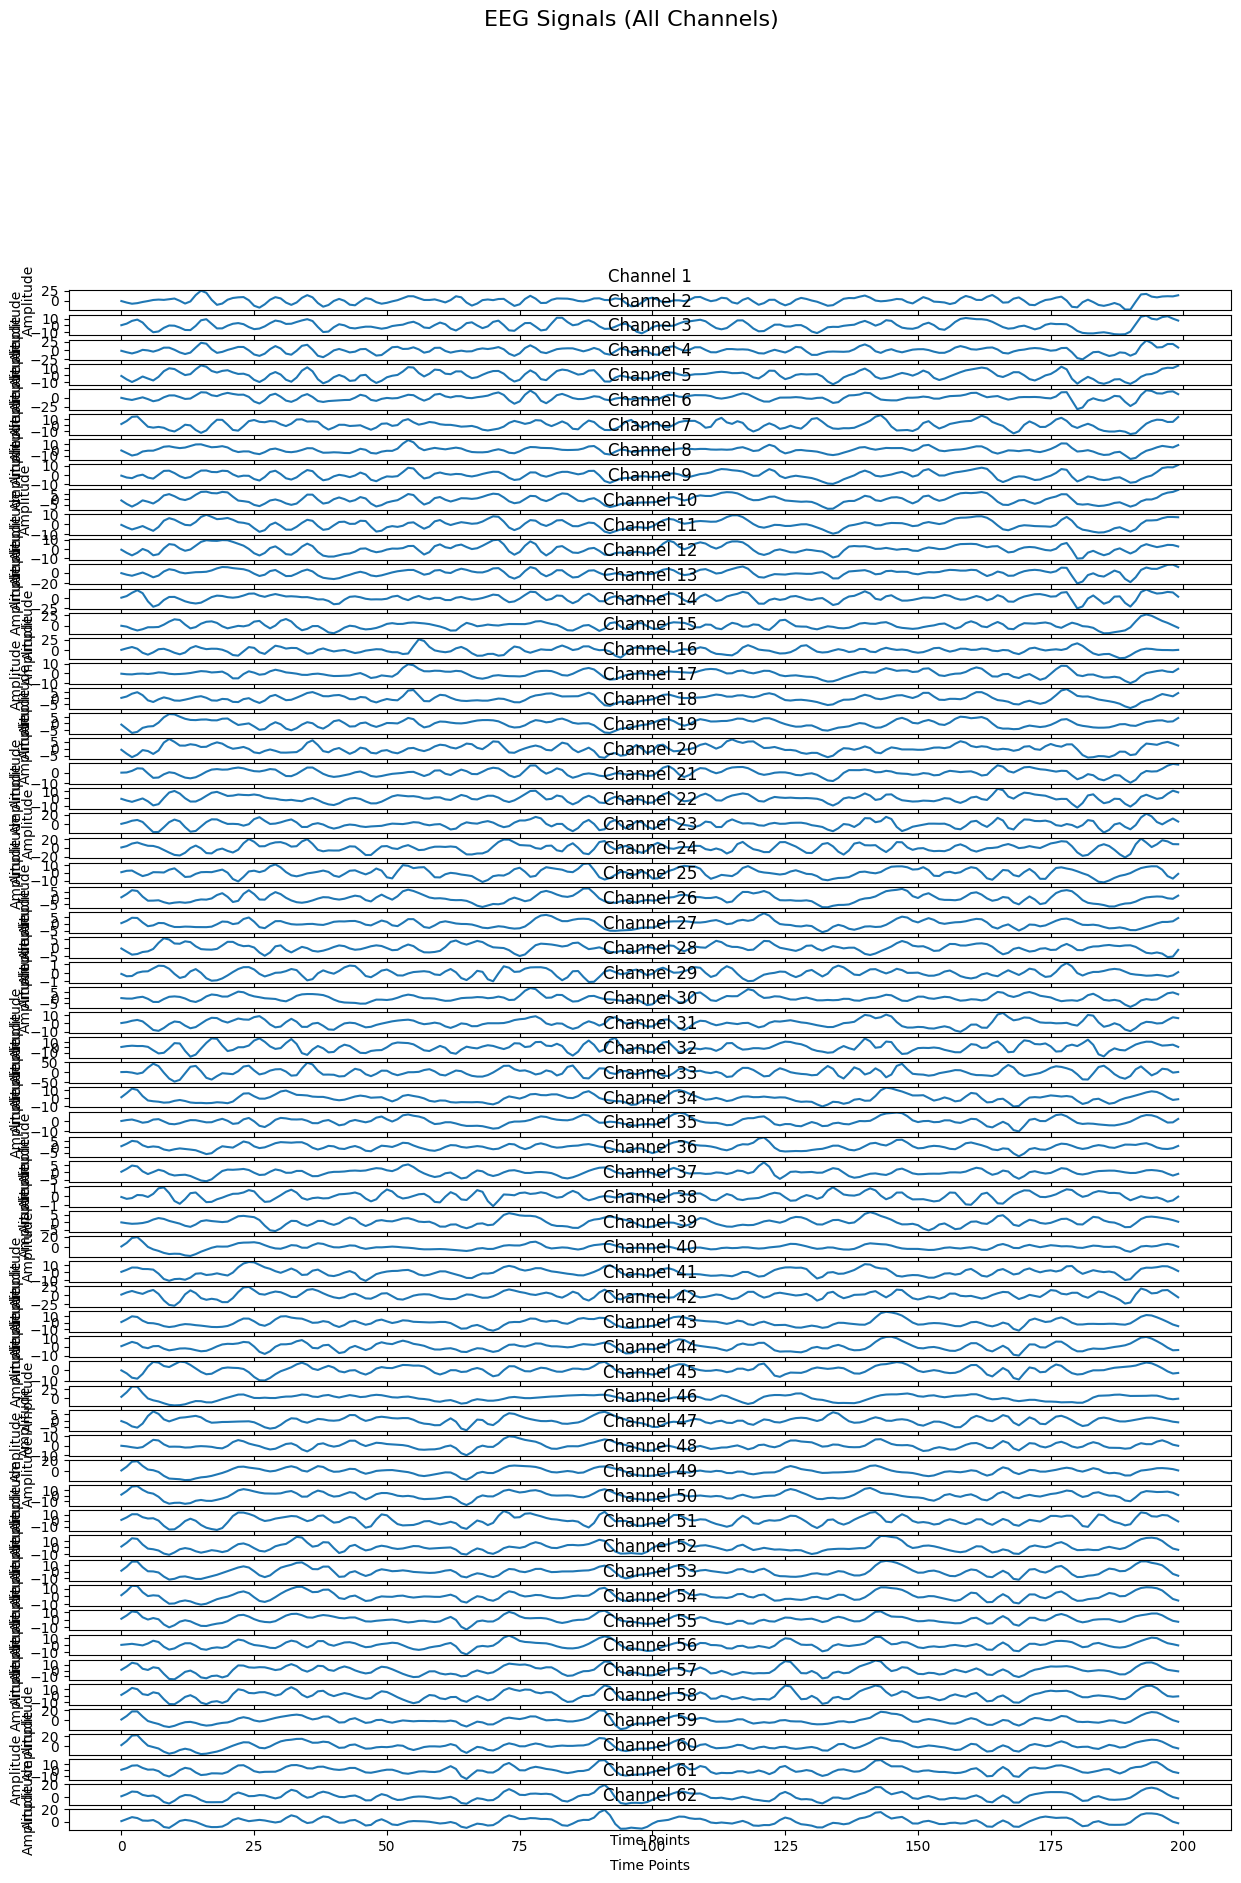

In [4]:
import matplotlib.pyplot as plt

def plot_all_channels(eeg_data, num_channels=62):
    """Plots all EEG channels."""
    plt.figure(figsize=(15, 20))
    
    for i in range(num_channels):
        plt.subplot(num_channels, 1, i + 1)
        plt.plot(eeg_data[i, :])
        plt.title(f'Channel {i + 1}')
        plt.xlabel("Time Points")
        plt.ylabel("Amplitude")
        plt.tight_layout()  # Adjust subplots to avoid overlap

    plt.suptitle("EEG Signals (All Channels)", fontsize=16, y=1.02)
    plt.show()

# Plot all channels for the first sample
plot_all_channels(first_sample)


In [ ]:
import numpy as np

def re_reference_to_average(dataset):
    re_referenced_dataset = []
    for sample, metadata in dataset:
        # Subtract the average of all channels
        mean_channel = np.mean(sample, axis=0, keepdims=True)
        re_referenced_sample = sample - mean_channel
        re_referenced_dataset.append((re_referenced_sample, metadata))
    return re_referenced_dataset

re_referenced_dataset = re_reference_to_average(cleaned_dataset)

In [9]:
print(f"Number of samples in the re-referenced dataset: {len(re_referenced_dataset)}")
print(f"Shape of the re-referenced EEG data: {re_referenced_dataset[0][0].shape}")
print(f"Metadata for the first sample: {re_referenced_dataset[0][1]}")
print(f"Re-referenced EEG data (first 5 channels, first 10 time points):")
print(re_referenced_dataset[0][0][:5, :10])

Number of samples in the re-referenced dataset: 10
Shape of the re-referenced EEG data: (62, 200)
Metadata for the first sample: {'start_at': 200, 'end_at': 400, 'clip_id': '10_20131130.mat_1', 'subject_id': 10, 'trial_id': 'ww_eeg1', 'emotion': 1, 'date': 20131130, '_record_id': '_record_0'}
Re-referenced EEG data (first 5 channels, first 10 time points):
[[ -1.60065305  -6.95380144 -12.09946969 -10.88461601  -5.4853797
   -0.85670058   2.28080629   3.65729067   4.27818421   7.04538107]
 [  0.07515278   0.73034961   2.50234186   4.10213685   2.39630243
   -3.53939367  -8.85652368  -7.365129    -0.71940707   3.65693826]
 [ -1.4873051   -7.2091792  -12.86029619  -8.98900945  -0.30645616
    0.3547854   -2.64882271   2.20930389  10.51939433  11.56627264]
 [ -1.77677833  -8.14747675 -14.09253161 -10.80933167  -4.09999589
   -4.69298675  -6.90649625  -1.40874745   7.9620044   13.08786315]
 [ -1.31292364  -6.23880746 -10.8291006   -7.41205105  -1.44322267
   -3.97604773  -9.26690644  -5.931

C:\Users\hasee\AppData\Local\Temp\ipykernel_6688\62455416.py:13: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Adjust subplots to avoid overlap


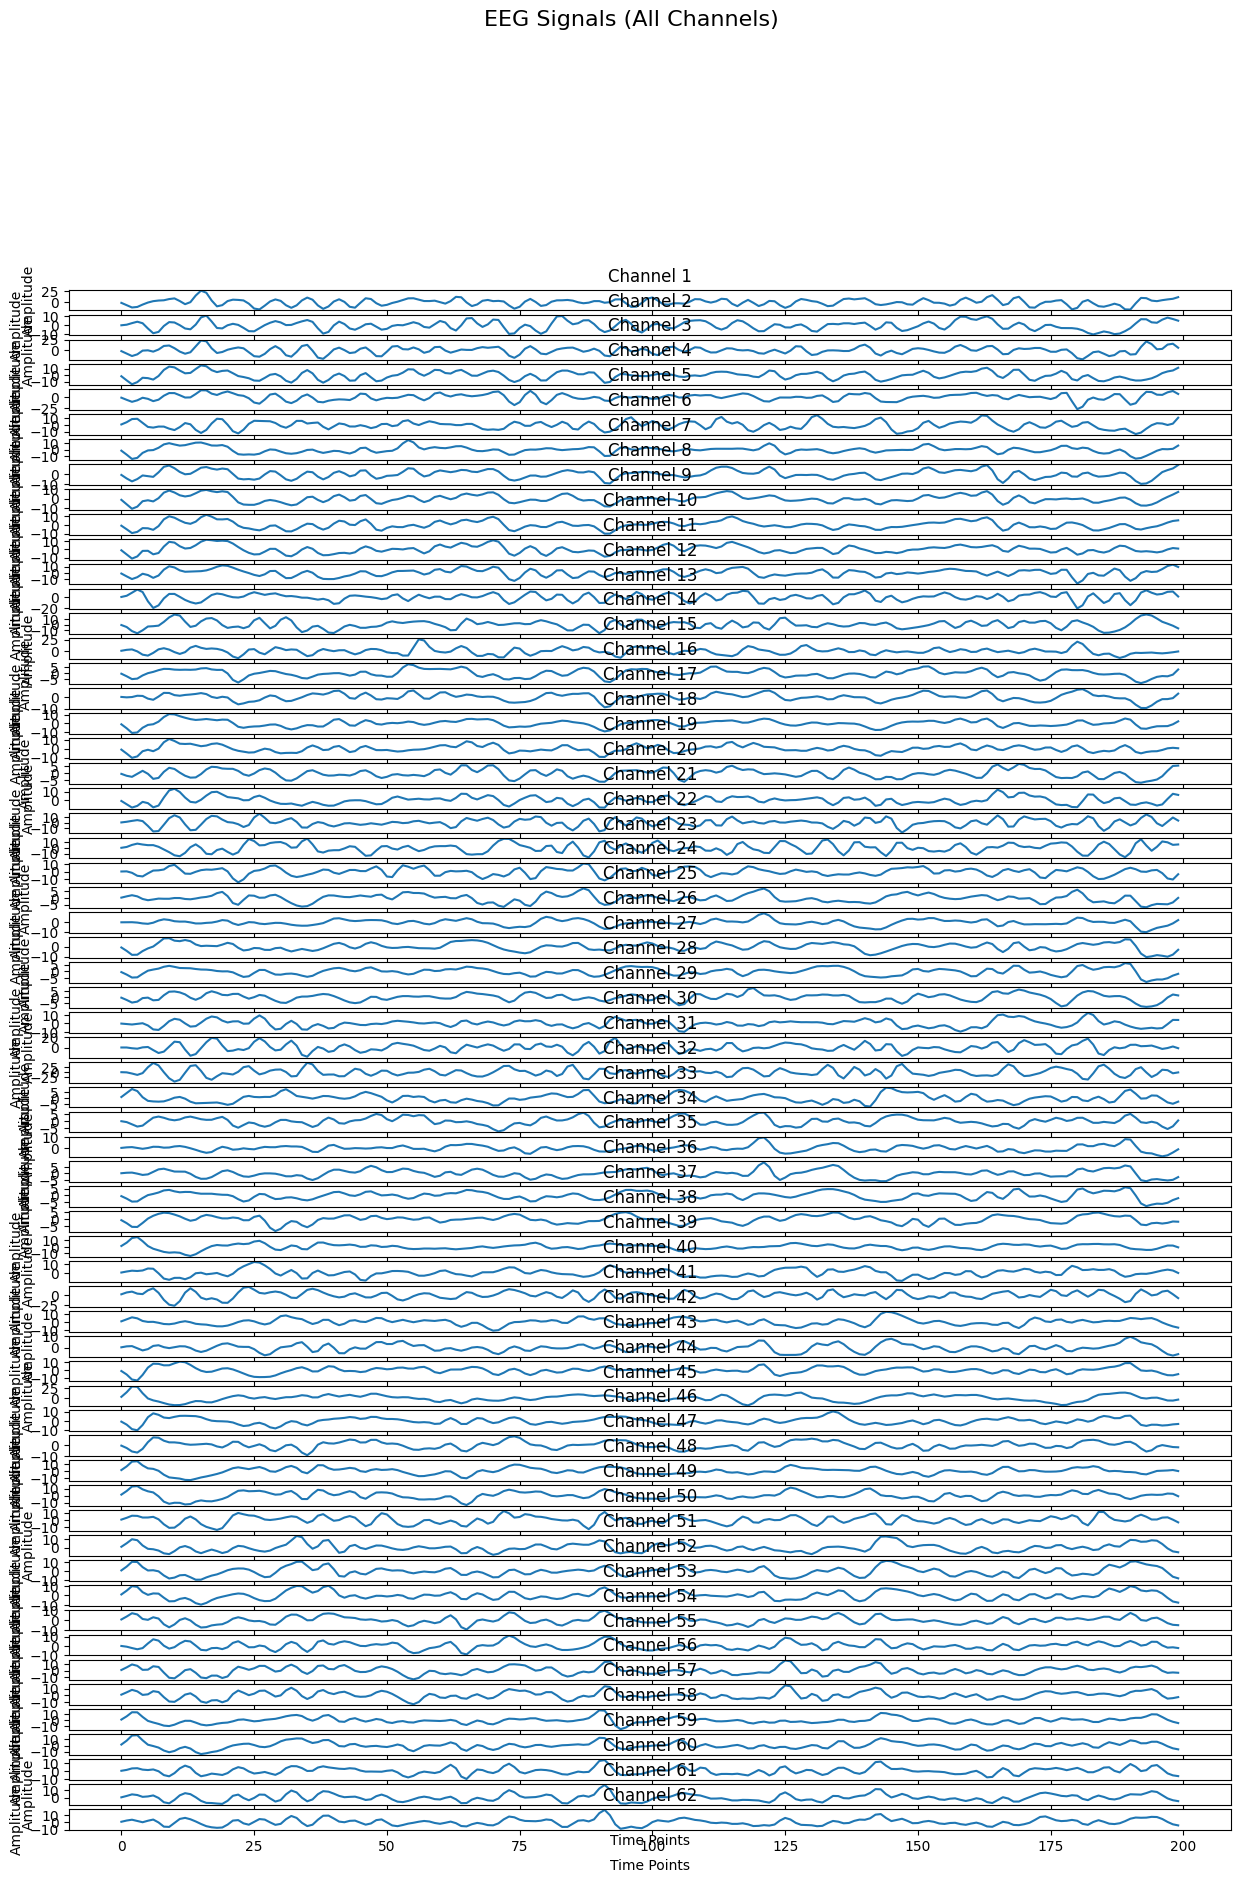

In [14]:
import matplotlib.pyplot as plt

def plot_all_channels(eeg_data, num_channels=62):
    """Plots all EEG channels."""
    plt.figure(figsize=(15, 20))
    
    for i in range(num_channels):
        plt.subplot(num_channels, 1, i + 1)
        plt.plot(eeg_data[i, :])
        plt.title(f'Channel {i + 1}')
        plt.xlabel("Time Points")
        plt.ylabel("Amplitude")
        plt.tight_layout()  # Adjust subplots to avoid overlap

    plt.suptitle("EEG Signals (All Channels)", fontsize=16, y=1.02)
    plt.show()

# Plot all channels for the first sample
plot_all_channels(re_referenced_dataset[0][0])


In [15]:
def segment_data(dataset, epoch_length=6000, step_size=3000):
    segmented_dataset = []
    for sample, metadata in dataset:
        num_points = sample.shape[1]
        for start in range(0, num_points - epoch_length + 1, step_size):
            segment = sample[:, start:start + epoch_length]
            segmented_dataset.append((segment, metadata))
    return segmented_dataset

segmented_dataset = segment_data(re_referenced_dataset)
print(f"Number of samples in the segmented dataset: {len(segmented_dataset)}")


Number of samples in the segmented dataset: 0
